### Imports and Options

#### Imports

In [29]:
%reload_ext autoreload
%autoreload 1
import duckdb
import pandas as pd
from IPython.display import Markdown, display
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import functions.display_functions as disf
%aimport functions.display_functions


#### Options

In [30]:
sns.set()
base_fig_width = 8
base_fig_height = 4.5

In [31]:
con = duckdb.connect()
con.execute(f"INSTALL sqlite")
con.execute(f"LOAD sqlite")
con.execute(f"SET GLOBAL sqlite_all_varchar=true")
con.execute(f"CALL sqlite_attach('data/database.sqlite')")

In [32]:
tables=con.query(
            f"""--sql
SELECT table_name as 'Table Name', COUNT(column_name) AS 'Column Count' FROM information_schema.columns GROUP BY table_name
"""
        ).to_df()

In [33]:
table_columns = con.query(
    f"""--sql
SELECT table_name,
    GROUP_CONCAT(column_name) AS column_names
FROM information_schema.columns
GROUP BY table_name"""
).to_df()
tables['column_names']=table_columns['column_names'].apply(lambda x: x.split(','))

In [34]:
row_counts={}
for table_name in tables['Table Name']:
    row_counts[table_name]=con.query(f"""--sql
                                     SELECT COUNT(*) FROM {table_name}
                                     """).fetchone()[0]
    

tables=tables.join(pd.Series(row_counts).rename('Row Count'), on='Table Name')

### Match

#### Preparing Match data

In [35]:
match_cols = tables.loc[tables["Table Name"] == "Match", "column_names"].to_list()[0]
match_cols_to_remove = ["league_id","stage","match_api_id","cross"]
match_cols = [col for col in match_cols if col not in match_cols_to_remove]
match_raw = con.query(f"""--sql
          SELECT {', '.join(match_cols)} FROM Match
          """).to_df()

#### What countries were the matches played in?

##### Fetching country ids:

In [36]:
country=con.query("""--sql
SELECT * FROM Country""").to_df().set_index('id')
country=country.to_dict()['name']

##### Plotting:

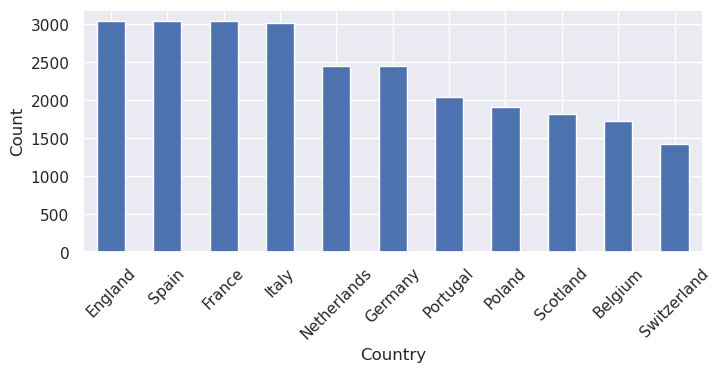

In [37]:
fig_match_country, ax_match_country = plt.subplots(
    figsize=(base_fig_width, 0.7*base_fig_height)
)
match_raw.value_counts("country_id").rename(country).plot.bar(ax=ax_match_country)
ax_match_country.set_xlabel('Country')
ax_match_country.set_ylabel('Count')
ax_match_country.tick_params(axis='x', rotation=45)
plt.show()

#### Whats the match distribution by date and season?

##### Preparing the season and date data:

In [38]:
match_raw["date"] = pd.to_datetime(match_raw["date"])
match_date_count = match_raw[["date", "id"]].resample("D", on="date").count().cumsum()

seasons=match_raw.groupby('season').agg(start=('date', 'min'),end=('date','max'),count=('season','count'))
seasons['length']=seasons['end']-seasons['start']


##### Plot:

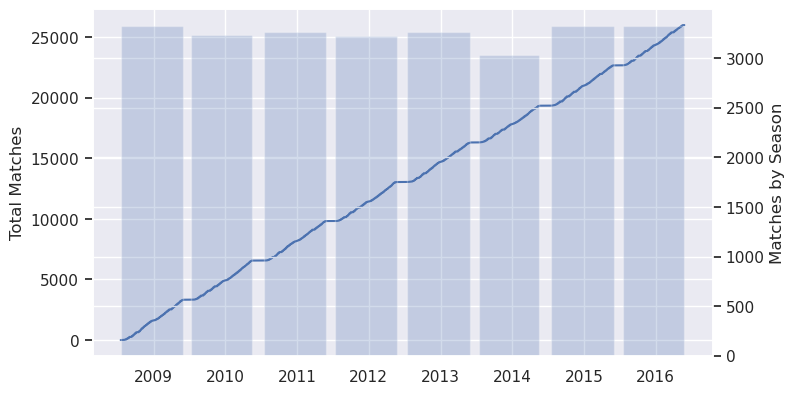

In [39]:


fig_match_count_date, ax_match_count_date = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)

ax_match_count_date.plot(match_date_count.index, match_date_count["id"])
ax_match_count_date_season = ax_match_count_date.twinx()
ax_match_count_date_season.bar(
    x=seasons["start"],
    height=seasons["count"],
    width=seasons["length"],
    align="edge",
    alpha=0.25,
)
ax_match_count_date.set_ylabel("Total Matches")
ax_match_count_date_season.set_ylabel("Matches by Season")

plt.show()

#### What is the distribution of goal difference between home and away teams?

##### Calculating the goal difference for each mach:

In [40]:
match_raw[["home_team_goal", "away_team_goal"]] = match_raw[
    ["home_team_goal", "away_team_goal"]
].astype(int)
match_raw["outcome"] = match_raw["home_team_goal"] - match_raw["away_team_goal"]
match_outcomes = match_raw["outcome"].value_counts().to_frame("count")
match_outcomes.reset_index(names=["value"], inplace=True)
match_outcomes["outcome"] = match_outcomes["value"].apply(
    lambda x: "Home Win" if x > 0 else ("Home Loss" if x < 0 else "Tie")
)
match_outcomes["color"] = match_outcomes["value"].apply(
    lambda x: sns.color_palette("muted")[0]
    if x > 0
    else (sns.color_palette("muted")[3] if x < 0 else sns.color_palette("muted")[4])
)

##### Plot:

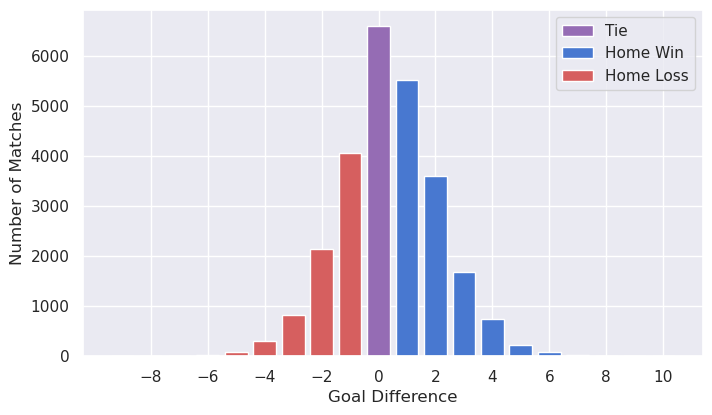

In [41]:
fig_match_outcomes,ax_match_outcomes=plt.subplots(figsize=(base_fig_width,base_fig_height))
ax_match_outcomes.bar(match_outcomes['value'],match_outcomes['count'],label=match_outcomes['outcome'],color=match_outcomes['color'],align='center')
handles, labels = ax_match_outcomes.get_legend_handles_labels()
ax_match_outcomes.legend(handles[:3],labels[:3])
ax_match_outcomes.set(xticks=np.arange(start=-8,stop=12,step=2))
ax_match_outcomes.set_ylabel('Number of Matches')
ax_match_outcomes.set_xlabel('Goal Difference')
plt.show()

#### Is there a home advantage?

##### Chi square test of non-tie matches with the null hypothesis being that there is an equal amount of home wins and away wins:

In [42]:
total_home_wins = match_outcomes.loc[match_outcomes['outcome'] == 'Home Win', 'count'].sum()
total_away_wins = match_outcomes.loc[match_outcomes['outcome'] == 'Home Loss', 'count'].sum()
home_advantage_result=stats.chisquare([total_home_wins,total_away_wins])

##### Results:

In [43]:
Markdown(f"""
Based on a chi-square test with a confidence level of 95%, the p-value of {home_advantage_result.pvalue:.2e}
strongly suggests that there is a significant home advantage.
{total_home_wins} of all non-tie wins were by the home team,
while only {total_away_wins} matches were won by away teams.
""")


Based on a chi-square test with a confidence level of 95%, the p-value of 2.82e-224
strongly suggests that there is a significant home advantage.
11917 of all non-tie wins were by the home team,
while only 7466 matches were won by away teams.


#### What are the different player combinations used?

##### Preparing player position combination columns:

In [49]:
# Getting lists of position column names
home_x_cols=[x for x in match_raw.columns.to_list() if 'home_player_X' in x]
home_y_cols=[x for x in match_raw.columns.to_list() if 'home_player_Y' in x]
away_x_cols=[x for x in match_raw.columns.to_list() if 'away_player_X' in x]
away_y_cols=[x for x in match_raw.columns.to_list() if 'away_player_Y' in x]

# Changing  the data type to numeric
match_raw[home_x_cols + home_y_cols + away_x_cols + away_y_cols] = match_raw[
    home_x_cols + home_y_cols + away_x_cols + away_y_cols
].apply(pd.to_numeric)

# Putting the home player coordinates into frozensets of (x,y) tuples
match_raw["combinations_home"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[home_x_cols], row[home_y_cols])]),
    axis=1,
)

# Changing any values that contain at least a single NaN value to Nan
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[away_x_cols], row[away_y_cols])]),
    axis=1,
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

In [50]:
pd.concat([match_raw['combinations_home'],match_raw['combinations_away']]).value_counts()

((3.0, 8.0), (5.0, 11.0), (4.0, 3.0), (5.0, 8.0), (1.0, 1.0), (4.0, 6.0), (2.0, 3.0), (8.0, 3.0), (6.0, 6.0), (6.0, 3.0), (7.0, 8.0))      12885
((4.0, 10.0), (2.0, 7.0), (4.0, 3.0), (8.0, 7.0), (1.0, 1.0), (2.0, 3.0), (6.0, 7.0), (8.0, 3.0), (6.0, 10.0), (6.0, 3.0), (4.0, 7.0))     12503
((7.0, 7.0), (4.0, 3.0), (3.0, 7.0), (1.0, 1.0), (7.0, 10.0), (3.0, 10.0), (5.0, 7.0), (2.0, 3.0), (8.0, 3.0), (5.0, 10.0), (6.0, 3.0))     8729
((5.0, 11.0), (7.0, 7.0), (4.0, 3.0), (3.0, 7.0), (1.0, 1.0), (5.0, 7.0), (2.0, 3.0), (8.0, 3.0), (1.0, 7.0), (6.0, 3.0), (9.0, 7.0))       2167
((5.0, 11.0), (2.0, 7.0), (4.0, 3.0), (8.0, 7.0), (1.0, 1.0), (2.0, 3.0), (6.0, 7.0), (8.0, 3.0), (5.0, 9.0), (6.0, 3.0), (4.0, 7.0))       1725
((8.0, 8.0), (5.0, 11.0), (4.0, 3.0), (1.0, 1.0), (6.0, 8.0), (2.0, 3.0), (8.0, 3.0), (5.0, 6.0), (4.0, 8.0), (6.0, 3.0), (2.0, 8.0))       1007
((4.0, 10.0), (7.0, 7.0), (4.0, 3.0), (3.0, 7.0), (1.0, 1.0), (5.0, 7.0), (7.0, 3.0), (1.0, 7.0), (3.0, 3.0), (6.0, 10.0), (9.0, 7

In [48]:
len(match_raw['combinations_home'].iloc[2])

TypeError: object of type 'float' has no len()

### Player attributes

array([[<Axes: title={'center': 'overall_rating'}>,
        <Axes: title={'center': 'potential'}>]], dtype=object)

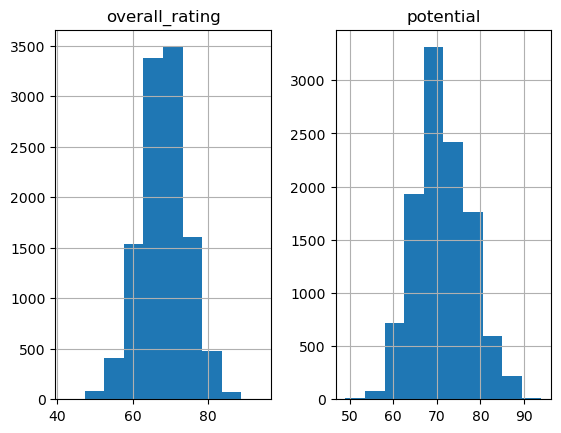

In [ ]:
rating_potential=con.query(
    """--sql
    SELECT overall_rating, potential
    FROM Player_Attributes p
    JOIN(
    SELECT player_api_id, MAX(date) AS max_date FROM Player_attributes GROUP BY player_api_id) sub 
    ON p.player_api_id=sub.player_api_id AND p.date=sub.max_date"""
).to_df()
rating_potential.dropna(inplace=True)
rating_potential=rating_potential.astype(int)
rating_potential.hist()

In [ ]:
Markdown(tabulate(con.query(
    """--sql
SELECT * from Player_Attributes LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   player_fifa_api_id |   player_api_id | date                |   overall_rating |   potential | preferred_foot   | attacking_work_rate   | defensive_work_rate   |   crossing |   finishing |   heading_accuracy |   short_passing |   volleys |   dribbling |   curve |   free_kick_accuracy |   long_passing |   ball_control |   acceleration |   sprint_speed |   agility |   reactions |   balance |   shot_power |   jumping |   stamina |   strength |   long_shots |   aggression |   interceptions |   positioning |   vision |   penalties |   marking |   standing_tackle |   sliding_tackle |   gk_diving |   gk_handling |   gk_kicking |   gk_positioning |   gk_reflexes |
|-----:|---------------------:|----------------:|:--------------------|-----------------:|------------:|:-----------------|:----------------------|:----------------------|-----------:|------------:|-------------------:|----------------:|----------:|------------:|--------:|---------------------:|---------------:|---------------:|---------------:|---------------:|----------:|------------:|----------:|-------------:|----------:|----------:|-----------:|-------------:|-------------:|----------------:|--------------:|---------:|------------:|----------:|------------------:|-----------------:|------------:|--------------:|-------------:|-----------------:|--------------:|
|    1 |               218353 |          505942 | 2016-02-18 00:00:00 |               67 |          71 | right            | medium                | medium                |         49 |          44 |                 71 |              61 |        44 |          51 |      45 |                   39 |             64 |             49 |             60 |             64 |        59 |          47 |        65 |           55 |        58 |        54 |         76 |           35 |           71 |              70 |            45 |       54 |          48 |        65 |                69 |               69 |           6 |            11 |           10 |                8 |             8 |
|    2 |               218353 |          505942 | 2015-11-19 00:00:00 |               67 |          71 | right            | medium                | medium                |         49 |          44 |                 71 |              61 |        44 |          51 |      45 |                   39 |             64 |             49 |             60 |             64 |        59 |          47 |        65 |           55 |        58 |        54 |         76 |           35 |           71 |              70 |            45 |       54 |          48 |        65 |                69 |               69 |           6 |            11 |           10 |                8 |             8 |
|    3 |               218353 |          505942 | 2015-09-21 00:00:00 |               62 |          66 | right            | medium                | medium                |         49 |          44 |                 71 |              61 |        44 |          51 |      45 |                   39 |             64 |             49 |             60 |             64 |        59 |          47 |        65 |           55 |        58 |        54 |         76 |           35 |           63 |              41 |            45 |       54 |          48 |        65 |                66 |               69 |           6 |            11 |           10 |                8 |             8 |
|    4 |               218353 |          505942 | 2015-03-20 00:00:00 |               61 |          65 | right            | medium                | medium                |         48 |          43 |                 70 |              60 |        43 |          50 |      44 |                   38 |             63 |             48 |             60 |             64 |        59 |          46 |        65 |           54 |        58 |        54 |         76 |           34 |           62 |              40 |            44 |       53 |          47 |        62 |                63 |               66 |           5 |            10 |            9 |                7 |             7 |
|    5 |               218353 |          505942 | 2007-02-22 00:00:00 |               61 |          65 | right            | medium                | medium                |         48 |          43 |                 70 |              60 |        43 |          50 |      44 |                   38 |             63 |             48 |             60 |             64 |        59 |          46 |        65 |           54 |        58 |        54 |         76 |           34 |           62 |              40 |            44 |       53 |          47 |        62 |                63 |               66 |           5 |            10 |            9 |                7 |             7 |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Player LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   player_api_id | player_name        |   player_fifa_api_id | birthday            |   height |   weight |
|-----:|----------------:|:-------------------|---------------------:|:--------------------|---------:|---------:|
|    1 |          505942 | Aaron Appindangoye |               218353 | 1992-02-29 00:00:00 |   182.88 |      187 |
|    2 |          155782 | Aaron Cresswell    |               189615 | 1989-12-15 00:00:00 |   170.18 |      146 |
|    3 |          162549 | Aaron Doran        |               186170 | 1991-05-13 00:00:00 |   170.18 |      163 |
|    4 |           30572 | Aaron Galindo      |               140161 | 1982-05-08 00:00:00 |   182.88 |      198 |
|    5 |           23780 | Aaron Hughes       |                17725 | 1979-11-08 00:00:00 |   182.88 |      154 |

### Teams

In [ ]:
con.query(
    f"""--sql
SELECT count(*) from Team"""
).to_df()

,count_star()
0,299


In [ ]:
con.query(
    f"""--sql
SELECT count(distinct team_api_id) from Team_Attributes"""
).to_df()

,count(DISTINCT team_api_id)
0,288


In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Team LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   team_api_id |   team_fifa_api_id | team_long_name    | team_short_name   |
|-----:|--------------:|-------------------:|:------------------|:------------------|
|    1 |          9987 |                673 | KRC Genk          | GEN               |
|    2 |          9993 |                675 | Beerschot AC      | BAC               |
|    3 |         10000 |              15005 | SV Zulte-Waregem  | ZUL               |
|    4 |          9994 |               2007 | Sporting Lokeren  | LOK               |
|    5 |          9984 |               1750 | KSV Cercle Brugge | CEB               |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Team_Attributes LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   team_fifa_api_id |   team_api_id | date                |   buildUpPlaySpeed | buildUpPlaySpeedClass   |   buildUpPlayDribbling | buildUpPlayDribblingClass   |   buildUpPlayPassing | buildUpPlayPassingClass   | buildUpPlayPositioningClass   |   chanceCreationPassing | chanceCreationPassingClass   |   chanceCreationCrossing | chanceCreationCrossingClass   |   chanceCreationShooting | chanceCreationShootingClass   | chanceCreationPositioningClass   |   defencePressure | defencePressureClass   |   defenceAggression | defenceAggressionClass   |   defenceTeamWidth | defenceTeamWidthClass   | defenceDefenderLineClass   |
|-----:|-------------------:|--------------:|:--------------------|-------------------:|:------------------------|-----------------------:|:----------------------------|---------------------:|:--------------------------|:------------------------------|------------------------:|:-----------------------------|-------------------------:|:------------------------------|-------------------------:|:------------------------------|:---------------------------------|------------------:|:-----------------------|--------------------:|:-------------------------|-------------------:|:------------------------|:---------------------------|
|    1 |                434 |          9930 | 2010-02-22 00:00:00 |                 60 | Balanced                |                    nan | Little                      |                   50 | Mixed                     | Organised                     |                      60 | Normal                       |                       65 | Normal                        |                       55 | Normal                        | Organised                        |                50 | Medium                 |                  55 | Press                    |                 45 | Normal                  | Cover                      |
|    2 |                434 |          9930 | 2014-09-19 00:00:00 |                 52 | Balanced                |                     48 | Normal                      |                   56 | Mixed                     | Organised                     |                      54 | Normal                       |                       63 | Normal                        |                       64 | Normal                        | Organised                        |                47 | Medium                 |                  44 | Press                    |                 54 | Normal                  | Cover                      |
|    3 |                434 |          9930 | 2015-09-10 00:00:00 |                 47 | Balanced                |                     41 | Normal                      |                   54 | Mixed                     | Organised                     |                      54 | Normal                       |                       63 | Normal                        |                       64 | Normal                        | Organised                        |                47 | Medium                 |                  44 | Press                    |                 54 | Normal                  | Cover                      |
|    4 |                 77 |          8485 | 2010-02-22 00:00:00 |                 70 | Fast                    |                    nan | Little                      |                   70 | Long                      | Organised                     |                      70 | Risky                        |                       70 | Lots                          |                       70 | Lots                          | Organised                        |                60 | Medium                 |                  70 | Double                   |                 70 | Wide                    | Cover                      |
|    5 |                 77 |          8485 | 2011-02-22 00:00:00 |                 47 | Balanced                |                    nan | Little                      |                   52 | Mixed                     | Organised                     |                      53 | Normal                       |                       48 | Normal                        |                       52 | Normal                        | Organised                        |                47 | Medium                 |                  47 | Press                    |                 52 | Normal                  | Cover                      |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Match LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   country_id |   league_id | season    |   stage | date                |   match_api_id |   home_team_api_id |   away_team_api_id |   home_team_goal |   away_team_goal |   home_player_X1 |   home_player_X2 |   home_player_X3 |   home_player_X4 |   home_player_X5 |   home_player_X6 |   home_player_X7 |   home_player_X8 |   home_player_X9 |   home_player_X10 |   home_player_X11 |   away_player_X1 |   away_player_X2 |   away_player_X3 |   away_player_X4 |   away_player_X5 |   away_player_X6 |   away_player_X7 |   away_player_X8 |   away_player_X9 |   away_player_X10 |   away_player_X11 |   home_player_Y1 |   home_player_Y2 |   home_player_Y3 |   home_player_Y4 |   home_player_Y5 |   home_player_Y6 |   home_player_Y7 |   home_player_Y8 |   home_player_Y9 |   home_player_Y10 |   home_player_Y11 |   away_player_Y1 |   away_player_Y2 |   away_player_Y3 |   away_player_Y4 |   away_player_Y5 |   away_player_Y6 |   away_player_Y7 |   away_player_Y8 |   away_player_Y9 |   away_player_Y10 |   away_player_Y11 |   home_player_1 |   home_player_2 |   home_player_3 |   home_player_4 |   home_player_5 |   home_player_6 |   home_player_7 |   home_player_8 |   home_player_9 |   home_player_10 |   home_player_11 |   away_player_1 |   away_player_2 |   away_player_3 |   away_player_4 |   away_player_5 |   away_player_6 |   away_player_7 |   away_player_8 |   away_player_9 |   away_player_10 |   away_player_11 |   goal |   shoton |   shotoff |   foulcommit |   card |   cross |   corner |   possession |   B365H |   B365D |   B365A |   BWH |   BWD |   BWA |   IWH |   IWD |   IWA |   LBH |   LBD |   LBA |   PSH |   PSD |   PSA |   WHH |   WHD |   WHA |   SJH |   SJD |   SJA |   VCH |   VCD |   VCA |   GBH |   GBD |   GBA |   BSH |   BSD |   BSA |
|-----:|-------------:|------------:|:----------|--------:|:--------------------|---------------:|-------------------:|-------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|-----------------:|-----------------:|-------:|---------:|----------:|-------------:|-------:|--------:|---------:|-------------:|--------:|--------:|--------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
|    1 |            1 |           1 | 2008/2009 |       1 | 2008-08-17 00:00:00 |         492473 |               9987 |               9993 |                1 |                1 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.73 |    3.4  |    5    |  1.75 |  3.35 |  4.2  |  1.85 |   3.2 |   3.5 |  1.8  |   3.3 |  3.75 |   nan |   nan |   nan |  1.7  |  3.3  |  4.33 |  1.9  |   3.3 |  4    |  1.65 |  3.4  |  4.5  |  1.78 |  3.25 |  4    |  1.73 |  3.4  |  4.2  |
|    2 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492474 |              10000 |               9994 |                0 |                0 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.95 |    3.2  |    3.6  |  1.8  |  3.3  |  3.95 |  1.9  |   3.2 |   3.5 |  1.9  |   3.2 |  3.5  |   nan |   nan |   nan |  1.83 |  3.3  |  3.6  |  1.95 |   3.3 |  3.8  |  2    |  3.25 |  3.25 |  1.85 |  3.25 |  3.75 |  1.91 |  3.25 |  3.6  |
|    3 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492475 |               9984 |               8635 |                0 |                3 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    2.38 |    3.3  |    2.75 |  2.4  |  3.3  |  2.55 |  2.6  |   3.1 |   2.3 |  2.5  |   3.2 |  2.5  |   nan |   nan |   nan |  2.5  |  3.25 |  2.4  |  2.63 |   3.3 |  2.5  |  2.35 |  3.25 |  2.65 |  2.5  |  3.2  |  2.5  |  2.3  |  3.2  |  2.75 |
|    4 |            1 |           1 | 2008/2009 |       1 | 2008-08-17 00:00:00 |         492476 |               9991 |               9998 |                5 |                0 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.44 |    3.75 |    7.5  |  1.4  |  4    |  6.8  |  1.4  |   3.9 |   6   |  1.44 |   3.6 |  6.5  |   nan |   nan |   nan |  1.44 |  3.75 |  6    |  1.44 |   4   |  7.5  |  1.45 |  3.75 |  6.5  |  1.5  |  3.75 |  5.5  |  1.44 |  3.75 |  6.5  |
|    5 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492477 |               7947 |               9985 |                1 |                3 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    5    |    3.5  |    1.65 |  5    |  3.5  |  1.6  |  4    |   3.3 |   1.7 |  4    |   3.4 |  1.72 |   nan |   nan |   nan |  4.2  |  3.4  |  1.7  |  4.5  |   3.5 |  1.73 |  4.5  |  3.4  |  1.65 |  4.5  |  3.5  |  1.65 |  4.75 |  3.3  |  1.67 |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from League"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|    id |   country_id | name                     |
|------:|-------------:|:-------------------------|
|     1 |            1 | Belgium Jupiler League   |
|  1729 |         1729 | England Premier League   |
|  4769 |         4769 | France Ligue 1           |
|  7809 |         7809 | Germany 1. Bundesliga    |
| 10257 |        10257 | Italy Serie A            |
| 13274 |        13274 | Netherlands Eredivisie   |
| 15722 |        15722 | Poland Ekstraklasa       |
| 17642 |        17642 | Portugal Liga ZON Sagres |
| 19694 |        19694 | Scotland Premier League  |
| 21518 |        21518 | Spain LIGA BBVA          |
| 24558 |        24558 | Switzerland Super League |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT league_id, count(id) from Match group by league_id"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   league_id |   count(id) |
|------------:|------------:|
|           1 |        1728 |
|        1729 |        3040 |
|        4769 |        3040 |
|        7809 |        2448 |
|       10257 |        3017 |
|       13274 |        2448 |
|       15722 |        1920 |
|       17642 |        2052 |
|       19694 |        1824 |
|       21518 |        3040 |
|       24558 |        1422 |